In [2]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366

In [2]:
ring2 = v2366(IDs='close', load_lattice=False)
chro = [1.6, 1.6]
ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)

[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019 0.002
 0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029 0.003
 0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039 0.004
 0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049 0.005
 0.0051 0.0052 0.0053 0.0054 0.0055 0.0056 0.0057 0.0058 0.0059 0.006
 0.0061 0.0062 0.0063 0.0064 0.0065 0.0066 0.0067 0.0068 0.0069 0.007
 0.0071 0.0072 0.0073 0.0074 0.0075 0.0076 0.0077 0.0078 0.0079 0.008 ]


/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  while exponent < min_n_risetimes / t[until-1]:
/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  while exponent < min_n_risetimes / t[until-1]:


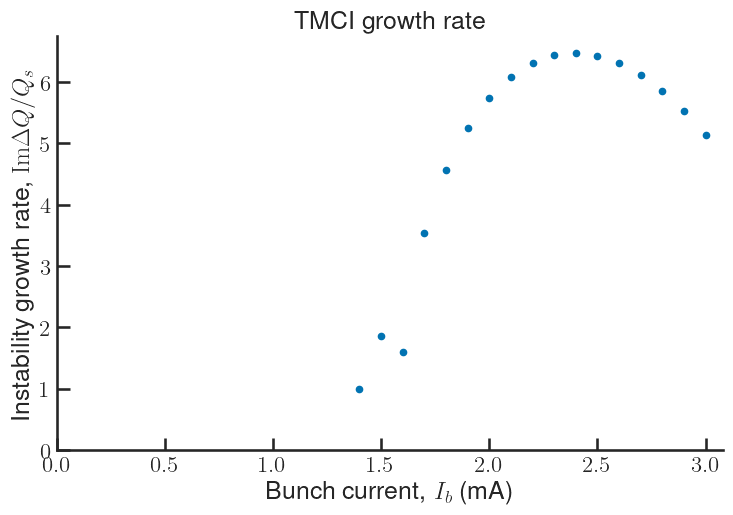

In [6]:
n_macroparticles=1e6
n_turns = 5e4
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 1.6
Qp_y = np.linspace(0.1, 5.0, 50)
tmci_current = 1e-3*np.linspace(0.1, 8, 80)
# tmci_current = 1e-3*np.linspace(0.1, 3, 30)


# tmci_current = 1e-3*np.linspace(0.1, 3, 30)
# for Qp in tqdm(Qp_y):
# for bunch_current in tqdm(tmci_current):
#     risetime, peak_freq, peak_amp, sigma_dp, sigma_z = post_single(n_macroparticles,
#                 n_turns, 
#                 n_bin,
#                 bunch_current, 
#                 Qp_x,
#                 Qp_x)
#     risetimes.append(risetime)
#     peak_freqs.append(peak_freq)
#     peak_amps.append(peak_amp)
#     sigmas_dp.append(sigma_dp)
#     sigmas_z.append(sigma_z)    

results = post_tmci_mwi_bunch_length(n_macroparticles=1e6,
                                     n_turns=5e4,
                                     n_bin=100,
                                     bunch_current_min=.1e-3,
                                     bunch_current_max=8e-3, 
                                     n_points=80)

Text(0, 0.5, 'Energy offset, $\\sigma_\\delta$ (\\%)')

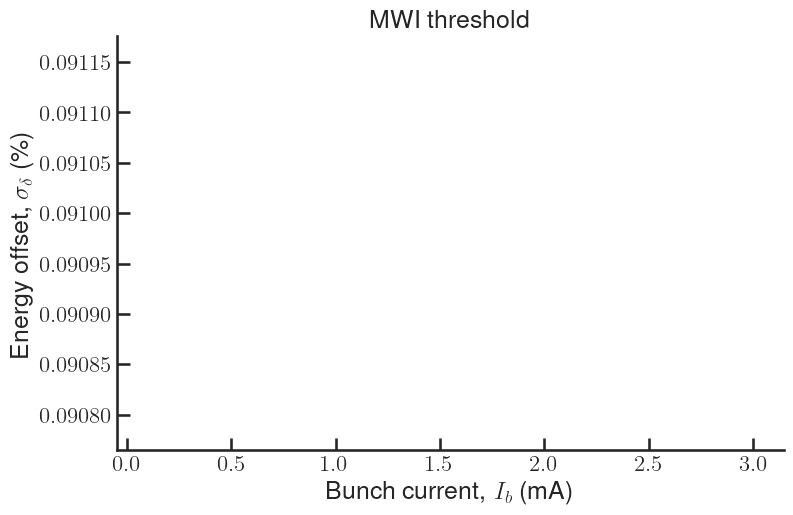

In [7]:
fig, ax = plt.subplots(1, 1)
sigmas_dp = results['FinalEnergyOffset'][:]
ax.plot(tmci_current*1e3, np.array(sigmas_dp)*1e2, marker='.')
ax.fill_between(tmci_current*1e3, results['MaxEnergyOffset'][:]*1e2, results['MinEnergyOffset'][:]*1e2, alpha=0.5, color='b')
ax.set_ylim(ring.sigma_delta*1e2,)
ax.title.set_text('MWI threshold')
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Energy offset, $\sigma_\delta$ (\%)')

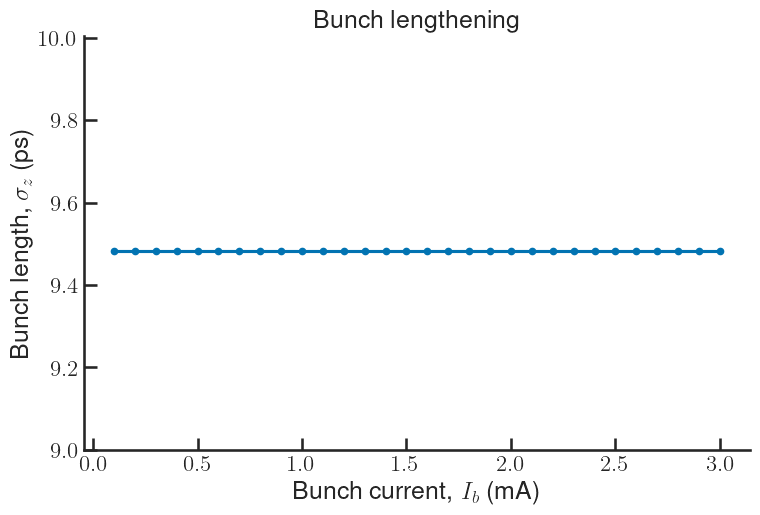

In [8]:
fig, ax = plt.subplots(1, 1)
sigmas_z = results['FinalBunchLength'][:]
ax.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12, marker='.')
ax.set_ylim(ring.sigma_0/1e-12)
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Bunch length, $\sigma_z$ (ps)')
ax.title.set_text('Bunch lengthening')

Text(0, 0.5, 'Instability growth rate, $\\mathrm{Im}\\Delta Q/Q_s$')

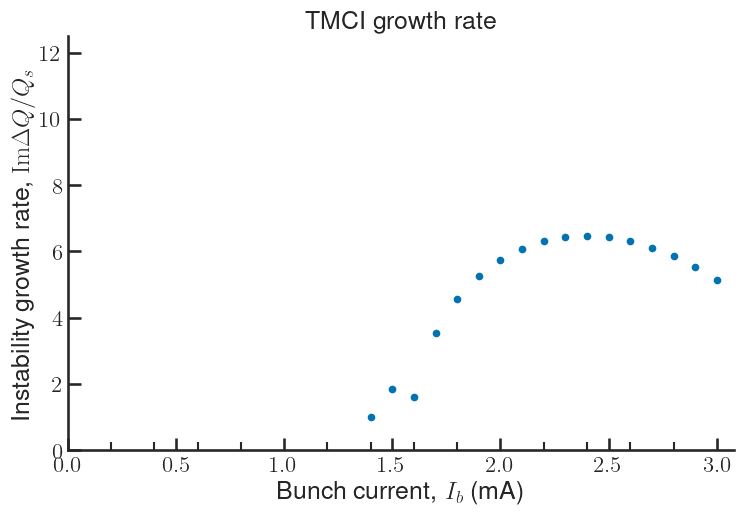

In [9]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots(1, 1)
ax.plot(tmci_current/1e-3, 2*pi/results['Risetime'][:]/Q_S, marker='.', linewidth=0)
# ax.axhline(2*pi/(ring.tau[2]*ring.f0)/Q_S, color='gray', linestyle='solid', label='Radiation damping')
ax.set_xlim(0,)
ax.set_ylim(0, 12.5)
ax.xaxis.set_minor_locator(MultipleLocator(.2))
ax.title.set_text('TMCI growth rate')
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Instability growth rate, $\mathrm{Im}\Delta Q/Q_s$')

NameError: name 'peak_freqs' is not defined

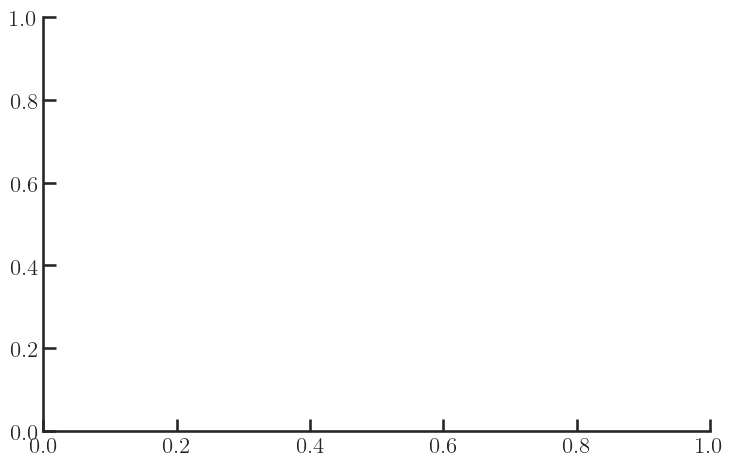

In [9]:
fig, ax = plt.subplots(1, 1)
for i, peak_freq in enumerate(peak_freqs):
    for p in peak_freq:
        ax.scatter(tmci_current[i]/1e-3, p, marker='.', color='black',)# alpha=peak_amps[i][p])
    
multiple_of=3
ax.set_ylim(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S)
ax.set_yticks(np.linspace(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S, 2*multiple_of+1))
labels = ['$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$']
for i in range(2, multiple_of+1):
    labels.insert(0, '$Q_y-{:}Q_s$'.format(i))
    labels.append('$Q_y+{:}Q_s$'.format(i))
ax.set_yticklabels(labels, rotation = 20)
# ax.title.set_text('Coherent betatron tune')
ax.yaxis.grid(True)
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Coherent betatron tune, $Q_b$')

ValueError: x and y must have same first dimension, but have shapes (50,) and (67,)

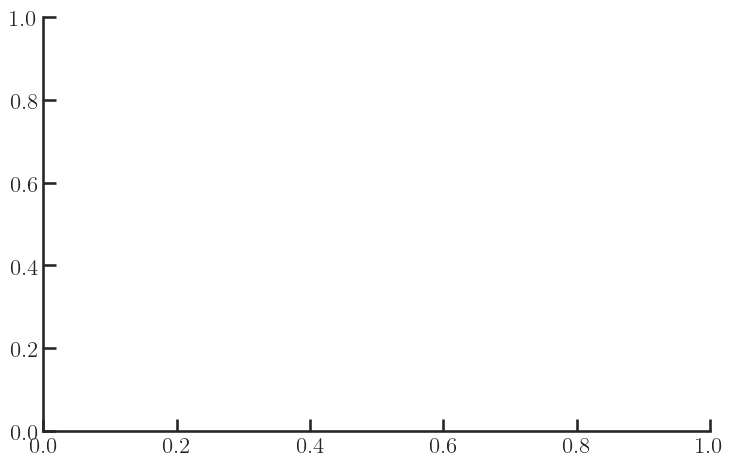

In [3]:
fig, ax = plt.subplots(1, 1)
ax.plot(Qp_y, 2*pi/np.array(risetimes)/Q_S, marker='.')
# ax.set_ylim(0, 1)

In [4]:
folder = '/home/gubaidulin/scripts/tracking/Results/IDsopen/tmci_scan_with_impedance/'
Qp_y = 0.0
Qp_x = 0.0
bunch_current = .6e-3
filename = folder+'monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f})'.format(
                                                                                                                        n_macroparticles,
                                                                                                                        n_turns, 
                                                                                                                        n_bin,
                                                                                                                        bunch_current, 
                                                                                                                        Qp_x,
                                                                                                                        Qp_y)
with hp.File(filename+'.hdf5') as f:
    print(f.keys())
    print(f['BunchData_0'].keys())
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]


<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>


(8.0, 25.0)

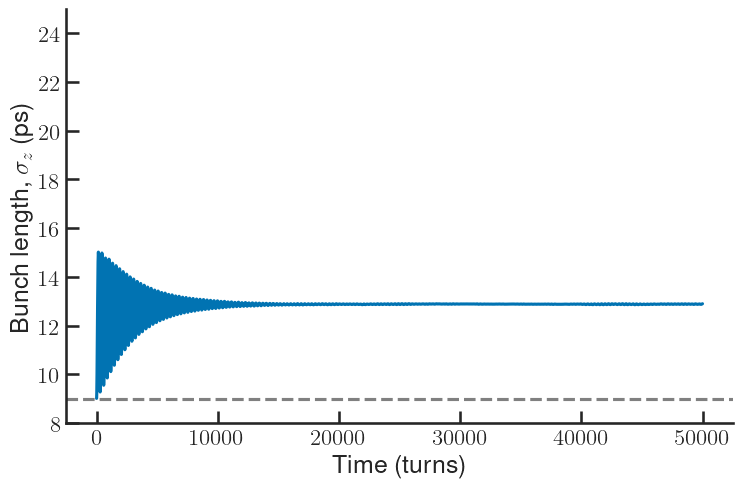

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.plot(std[4,:]/1e-12)
# ax.plot(m[0,:]/std[0,0])
ax.axhline(ring.sigma_0/1e-12, color='gray', linestyle='dashed', label='')
ax.set_ylabel('Bunch length, $\sigma_z$ (ps)')
ax.set_xlabel('Time (turns)')
ax.set_ylim(8, 25)
# ax.plot()

In [15]:
%matplotlib inline
n_macroparticles = 1e6
# wakefield.plot_last_wake(wake_type='Wydip')
# filename = 'monitors(n_mp=1.0e+06,n_turns=5.0e+04,n_bin=100,bunch_current=1.0e-03,Qp_x=1.60,Qp_y=1.60)'
# filename = 'monitors(n_mp=5.0e+05,n_turns=5.0e+04,n_bin=100,bunch_current=1.0e-03,Qp_x=1.60,Qp_y=1.60)'
# FOLDER = '/home/gubaidulin/scripts/tracking/Results/chroma_scan/'
# FOLDER_FIG = 'Figures/chroma_scan/'
Qp_y = np.linspace(0.01, 5.0, 50)[3]
filename = 'monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f})'.format(n_macroparticles,
                                                                                                                        n_turns, 
                                                                                                                        n_bin,
                                                                                                                        bunch_current, 
                                                                                                                        Qp_x,
                                                                                                                        Qp_y)

In [14]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
filename = 'monitors(n_mp=1.0e+04,n_turns=1.0e+04,n_bin=100,bunch_current=1.2e-03,Qp_x=0.00,Qp_y=0.00)'
file = hp.File(filename+'.hdf5')

with hp.File(filename+'.hdf5') as f:
    print(f['Beam'].keys())
    # m = f['BunchData_0']['mean'][:]
    # std = f['BunchData_0']['std'][:]
    # J = f['BunchData_0']['cs_invariant'][:]
    # emit = f['BunchData_0']['emit'][:]
#     
    mb = f['Beam']['mean'][:]
    stdb = f['Beam']['std'][:]
    Jb = f['Beam']['cs_invariant'][:]
    emitb = f['Beam']['emit'][:]


KeyError: "Unable to open object (object 'Beam' doesn't exist)"

(6, 416, 20000)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


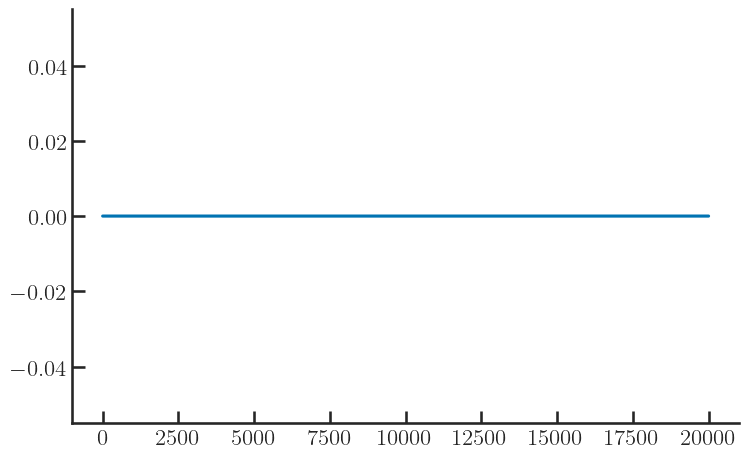

In [13]:
print(mb.shape)
print(emitb)
plt.plot(np.mean(mb[0,:, :], axis=0))

0.0019479947512890817


(241,)

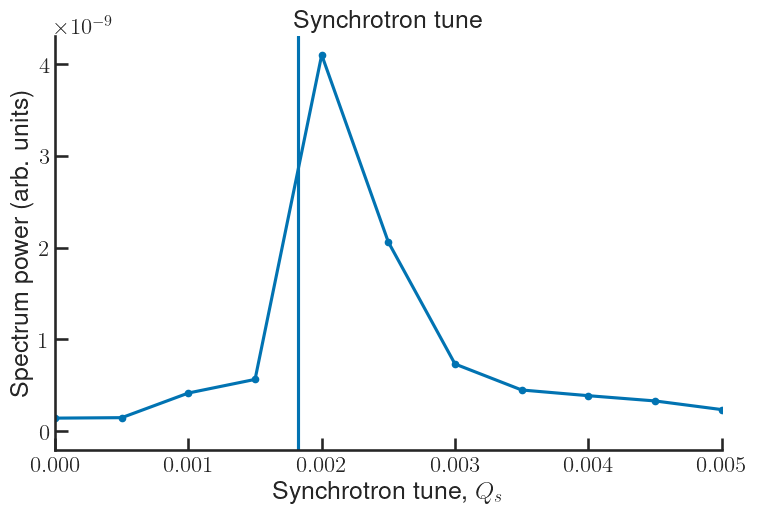

In [7]:
from scipy.signal import find_peaks
fftz = np.abs(np.fft.rfft(m[4,:])-np.mean(np.fft.rfft(m[4,:])))
fftfreqz = np.fft.rfftfreq(m[4,:].shape[0])
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqz, fftz, marker='.')
ax.set_xlim(0, 5e-3)
ax.axvline(1.82e-3)
print(Q_S)
ax.set_ylabel('Spectrum power (arb. units)')
ax.set_xlabel('Synchrotron tune, $Q_s$')
ax.title.set_text('Synchrotron tune')
# plt.savefig(FOLDER_FIG+'synchrotron_tune(Qp_y={:}).pdf'.format(int(Qp_y)))
find_peaks(fftz)[0].shape

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  while exponent < min_n_risetimes / t[until-1]:


NameError: name 'n_macroparticles' is not defined

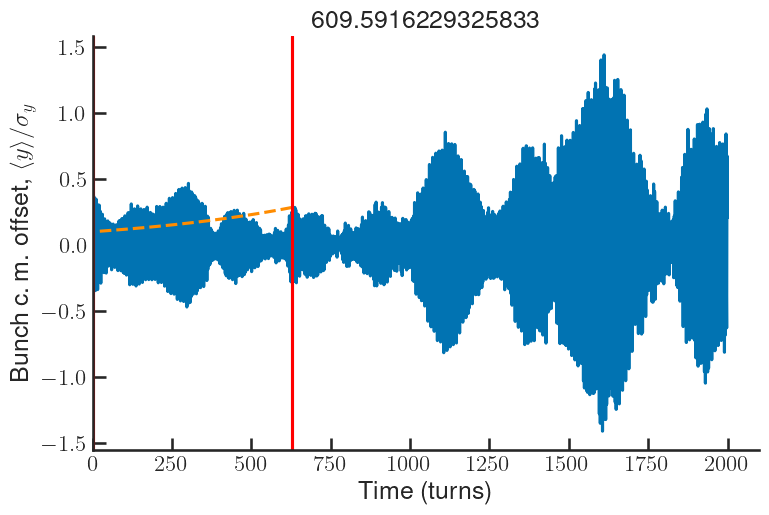

In [8]:
fig, ax = plt.subplots()
ax.plot(m[2,:]/std[2, 0])
min_level = 0.05
signal = np.sqrt(m[2,:]**2+(BETA_Y_SMOOTH*m[3,:])**2)/std[2,0]
smoothing_window_size = 200
risetime = fit_risetime(signal,
                      min_level=min_level, 
                      smoothing_window_size=smoothing_window_size,
                      matplotlib_axis=ax)
ax.set_xlabel('Time (turns)')
ax.set_ylabel('Bunch c.\,m. offset, $\langle y \\rangle/\sigma_y$')
ax.set_xlim(0, )
ax.title.set_text('Risetime of {:} turns, $N_m={:.1e}$'.format(int(risetime), n_macroparticles))
# plt.savefig(FOLDER_FIG+'beam_offset(Qp_y={:}).pdf'.format(Qp_y))

['$Q_y-5Q_s$', '$Q_y-4Q_s$', '$Q_y-3Q_s$', '$Q_y-2Q_s$', '$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$', '$Q_y+2Q_s$', '$Q_y+3Q_s$', '$Q_y+4Q_s$', '$Q_y+5Q_s$']


NameError: name 'n_macroparticles' is not defined

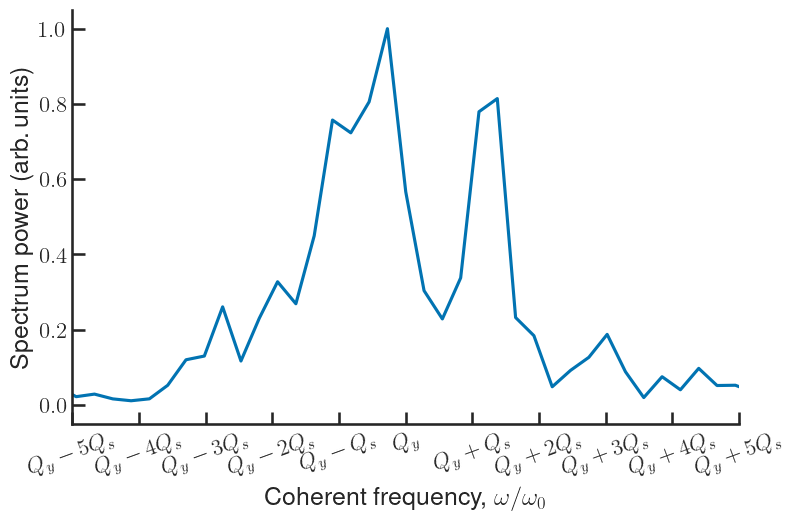

In [9]:
%matplotlib inline
ffty = np.abs(np.fft.rfft(m[2,:]))
fftfreqy = np.fft.rfftfreq(m[2,:].shape[0])
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqy, ffty/np.max(ffty))
# ax.set_xlim(0, 5e-3)
Q_S=1.82e-3
multiple_of = 5
ax.set_xlabel('Coherent frequency, $\omega/\omega_0$')
ax.set_ylabel('Spectrum power (arb.\,units)')
ax.set_xlim(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S)
ax.set_xticks(np.linspace(Q_Y-np.floor(Q_Y)-multiple_of*Q_S, Q_Y-np.floor(Q_Y)+multiple_of*Q_S, 2*multiple_of+1))
labels = ['$Q_y-Q_s$', '$Q_y$', '$Q_y+Q_s$']
for i in range(2, multiple_of+1):
    labels.insert(0, '$Q_y-{:}Q_s$'.format(i))
    labels.append('$Q_y+{:}Q_s$'.format(i))
print(labels)
ax.set_xticklabels(labels, rotation = 20)
ax.title.set_text('Coherent betatron tune, N_m={:.1e}'.format(n_macroparticles))
ax.xaxis.grid(True)
# plt.savefig(FOLDER_FIG+'coherent_betatron_tune(Qp_y={:}).pdf'.format((Qp_y)))
peaks = find_peaks(ffty/np.max(ffty), height=0.1, distance=20)
print(fftfreqy[peaks[0]])
print(ffty[peaks[0]])
import PyNAFF as pnf
# n = pnf.naff(m[2,:], turns=m[2,:].shape[0], nterms=500, skipTurns=0, getFullSpectrum=False, window=1)
for p in fftfreqy[peaks[0]]:
    plt.axvline(p)

In [29]:
with hp.File(filename+'.hdf5') as f:
    print(f['WakePotentialData_0'].keys())
    dip_y = f['WakePotentialData_0']['dipole_Wydip'][:]
    profile_y = f['WakePotentialData_0']['profile_Wydip'][:]
    tau_y = f['WakePotentialData_0']['tau_Wydip'][:]

<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


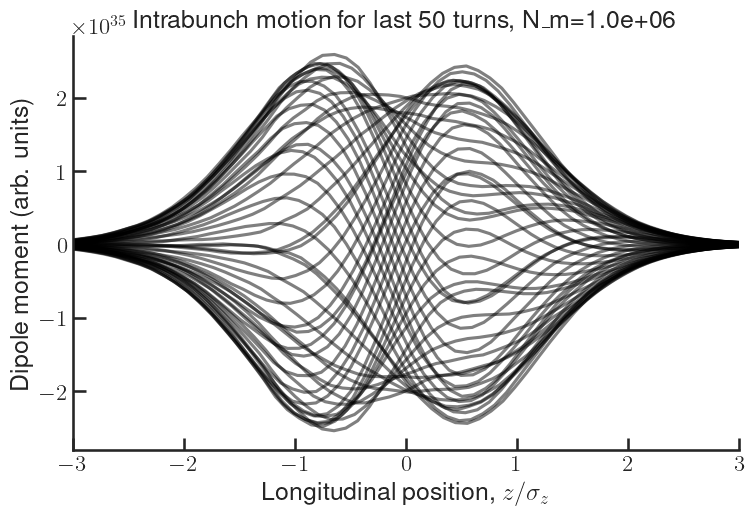

In [30]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 44950 
lineend =45000
# ax.plot((tau_y[:,-linenumber:])*c/SIGMA_Z, profile_y[:,-linenumber:], color='black', alpha=0.5)

ax.plot((tau_y[:,linestart:lineend])*c/SIGMA_Z, dip_y[:,linestart:lineend]*profile_y[:,linestart:lineend], color='black', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
plt.savefig(FOLDER_FIG+'intrabunch_motion(Qp_y={:}).pdf'.format(Qp_y))